
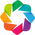

In [2]:
import pandas as pd
import numpy as np
from ipywidgets import *
from IPython.display import display
from IPython.html.widgets import *
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import json
import matplotlib.pyplot as plt
import numpy as np
import holoviews as hv
hv.notebook_extension('bokeh')
%output fig='html'
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.plotting import figure
#%load_ext holoviews.ipython
from matplotlib.image import imread
%output backend='bokeh'
%output widgets='live'
%output holomap='scrubber'
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('week7.csv', header=0, parse_dates=['hour'])
regions=pd.read_csv('regions.csv',sep=';')
regions.columns=['zone','west','east','south','north']
variables=['hour','zone','output1','forecast_1']
data=data[variables]
data=pd.merge(data, regions, how='left', on='zone')
data['time']=data['hour'].apply(lambda x: x + pd.Timedelta(hours=1))

#### Временной ряд фактического и прогнозируемого спроса на такси в выбираемой области (по часам, дням и неделям)


In [4]:
time_dct={'hourly':"H",'daily':"D",'weekly':'W'} 
def handle_change(w,f):
    plt.style.use('fivethirtyeight')
    csfont = {'fontname':'Comic Sans MS','fontsize':30}
    dframe=data[['time','output1','forecast_1']][data.zone==w]
    dframe.columns=['hour','quantity','forecast']
    dframe=dframe.set_index('hour')
    dframe=dframe.groupby(pd.TimeGrouper(freq=time_dct[f]))[['quantity','forecast']].mean().plot(figsize=(25, 8),style=['ro-','bo-'])
    plt.legend(loc='upper right',fontsize=20)
    plt.title("Zone "+str(w),**csfont)
    plt.xticks(rotation=17,fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
interact(handle_change, w=data.zone.unique(), f=['hourly','daily','weekly'])

A Jupyter Widget

<function __main__.handle_change>

In [5]:
west, south, east, north = -74.25559, 40.49612, -73.70001, 40.91553
step1=(74.25559-73.70001)/50
step2=(40.91553-40.49612)/50
bin_long=np.arange(-74.25559, -73.7000, step1)
bin_lat=np.arange(40.49612, 40.91554, step2)
m = Basemap(projection='lcc', lat_0=south, lat_1=(north+south)/2, lon_0=(west+east)/2, resolution='h',
        llcrnrlat=south, urcrnrlat=north, llcrnrlon=west, urcrnrlon=east)

#### Ниже визуализация фактического количества и прогноза на карте (значения можно увидеть в всплывающих pop-up, можно выбрать часы и даты до 11 июня 2016)

In [8]:
geo_dct={}
def geo_json(x):
    dct={
                "id": x[0],
                "quantity":x[6],
                "forecast":x[7],
                "time": x[1],
                'lons':(x[2]+x[3])/2,
                'lats':(x[4]+x[5])/2,
            }
    geo_dct[(x[0],x[1])]=dct
    return geo_dct 
hframe=data[['zone','time','west','east','south','north','output1','forecast_1']]
hframe.apply(lambda x: geo_json(x), axis=1)
county_xs = [m(gdct["lons"], gdct["lats"])[0] for gdct in geo_dct.values()]
county_ys = [m(gdct["lons"], gdct["lats"])[1] for gdct in geo_dct.values()]
county_time = [gdct['time'] for gdct in geo_dct.values()]
county_names = [gdct['id'] for gdct in geo_dct.values()]
county_rates = [gdct['quantity'] for gdct in geo_dct.values()]
county_rates2 = [gdct['forecast'] for gdct in geo_dct.values()]
source = pd.DataFrame(data=dict(
    x=county_xs,
    y=county_ys,
    name=county_names,
    quantity=county_rates,
    forecast=county_rates2,
    time=county_time
))
contours = hv.Contours([poly.get_coords() for poly in m.landpolygons],
                        group='Continents', kdims=['Longitude', 'Latitude'])
hourly_df = source.groupby([source.time])
daily_qf = hv.HoloMap(kdims=['time'])
for time, dat in hourly_df:
    time = str(time)
    daily_qf[time] = (contours * 
                               hv.Scatter(dat, vdims=['name','quantity','forecast'], kdims=['x','y']))

%opts Overlay [width=600 height=600] Scatter [color_index=3 tools=['hover']] (cmap="YlOrRd" marker='s' size=9)
%opts Contours (color='brown')
daily_qf

:HoloMap   [time]
   :Overlay
      .Continents.I :Contours   [Longitude,Latitude]   (Level)
      .Scatter.I    :Scatter   [x,y]   (name,quantity,forecast)

#### Еще одна визуализация на карте (так себе)

In [9]:
def choose_date(day, hour):
    hframe=data[['zone','output1','forecast_1']][(data.time.dt.date==day)& (data.time.dt.hour==hour)]
    olst=[]
    flst=[]
    for i in range(1,2501):
        if i not in hframe.zone.unique():
            olst.append(0)
            flst.append(0)
        else:
            olst.append(hframe['output1'][hframe.zone==i])
            flst.append(hframe['forecast_1'][hframe.zone==i])
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    plt.title('Quantity')
    m.drawcoastlines()
    x = bin_long
    y = bin_lat
    X,Y = m(*np.meshgrid(x,y))
    Z = np.array(olst).reshape(50,50).T
    plt.pcolormesh(X, Y, Z, cmap=cm.YlOrRd_r)
    ax = fig.add_subplot(122)
    plt.title('Forecast')
    m.drawcoastlines()
    x = bin_long
    y = bin_lat
    X,Y = m(*np.meshgrid(x,y))
    Z = np.array(flst).reshape(50,50).T
    plt.pcolormesh(X, Y, Z, cmap=cm.YlOrRd_r)
    plt.show()
interact(choose_date, day=data.time.dt.date.unique(), hour=(0,23))

A Jupyter Widget

<function __main__.choose_date>